# AI - CA3 - Naive Bayes - Mohamad Taha Fakharian

## Goal
In this assignment, we're going to 

## Overall approach


In [95]:
from __future__ import unicode_literals
from hazm import *
import nltk
import re

from operator import itemgetter
from bidi.algorithm import get_display
from arabic_reshaper import reshape

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
train_data = pd.read_csv('Data/train.csv', encoding='utf-8')
test_data = pd.read_csv('Data/test.csv', encoding='utf-8')

In [97]:
train_data

,content,label
0,فیلم‌های در حال اکران؛ موزیکال شاد خاله قورباغ...,هنر و سینما
1,پنج فیلمسازی که کوئنتین تارانتینو را عاشق سینم...,هنر و سینما
2,جانی آیو از اپل رفت جانی آیو دیگر نیازی به معر...,علم و تکنولوژی
3,احتمال عدم پشتیبانی iOS ۱۳ از آیفون ۵ اس، SE و...,علم و تکنولوژی
4,دزدان مغازه نماینده ژاپن در اسکار ۲۰۱۹ شد فیلم...,هنر و سینما
...,...,...
5195,امپراطوری اپ (فصل اول/بخش دوم) فصل اول – بخش د...,سلامت و زیبایی
5196,عدم ارتباطات اثربخش و تعارض در محیط کار وجود س...,سلامت و زیبایی
5197,اپل در سال ۲۰۲۰ چهار آیفون معرفی خواهد کرد! طب...,علم و تکنولوژی
5198,مارتینز: بلژیک باید مقابل فرانسه بدون ترس بازی...,سلامت و زیبایی


In [98]:
labels = train_data['label'].unique()

In [100]:
labels_frequency = train_data['label'].value_counts()

In [101]:
stemmer = Stemmer()
normalizer = Normalizer()
lemmatizer = Lemmatizer()

In [102]:
with open('stop_words.txt', 'r', encoding='utf-8') as stop:
    words = [word.replace('\u200c',' ').strip() for word in stop if word]
    words.extend(['\n', '\r'])
    stop_words = set(words)

In [103]:
stop_words

{'جدید',
 'تک تک',
 'گفتیم',
 'بیاب',
 'هر چه',
 'شدن',
 '۵',
 'اخیراً',
 'خالصانه',
 'حال',
 'دم',
 'گیرید',
 'توانستیم',
 'به سرعت',
 'همیشه',
 'روش',
 'همه',
 'عموم',
 'ج',
 'سوی',
 'هیچی',
 'خصوصاً',
 'بودن',
 'زیرا',
 'از جمله',
 'خیاه',
 '[',
 'راحت',
 'دیوانه ای',
 'آقای',
 'برداری',
 'اینچنین',
 'سیخ',
 'با',
 'وگو',
 'کلیه',
 'دیگر',
 'به مراتب',
 'داشته',
 'عجب',
 'گفت',
 'شود',
 'ناگهانی',
 '(',
 'سر',
 'یکریز',
 'بی آنکه',
 'قاطبه',
 'گذشته',
 'یک چیزی',
 'گاه',
 'تریلیارد',
 'بیابیم',
 'راه',
 'اینقدر',
 'همگی',
 'فوق',
 'نزدیکِ',
 'آیند',
 'قدر',
 'درین',
 'ل',
 'رنجند',
 'جا',
 'یابد',
 'ساده اند',
 'چیست',
 'بخواه',
 'باد',
 'سویِ',
 'مسلما',
 'بخواهید',
 'اگه',
 'ش',
 'کردند',
 'یواش یواش',
 'حاضرم',
 'بدانجا',
 'نمی کند',
 'آنطور',
 'امیدوارند',
 'دایما',
 'به ناچار',
 'هزار',
 'مکرر',
 'بی',
 'جداً',
 'عجولانه',
 'میلیون',
 'دامم',
 'چندان',
 'باوجودی که',
 'اری',
 'برابر',
 'مغرضانه',
 'همزمان',
 'راستی',
 'هنگامی',
 'حقیرانه',
 'نگو',
 'بخش',
 'معتقدم',
 'و لا غیر'

In [104]:
flags = {
    'stem' : False,
    'normalize' : False,
    'lemmatize' : False
}

In [105]:
def preprocess(data, flags=flags):
    stem = flags['stem']
    normalize = flags['normalize']
    lemmatize = flags['lemmatize']
    
    data = str(data).replace('\u200c',' ')
    data = normalizer.normalize(data) if normalize else data
    
    words = word_tokenize(data)
    words = list(map(stemmer.stem, words)) if stem else words
    words = list(map(lemmatizer.lemmatize, words)) if lemmatize else words
    
    words = [word for word in words if word not in stop_words]
    return words

In [106]:
preprocess(train_data['content'][0], flags)

['فیلم',
 'اکران',
 'موزیکال',
 'شاد',
 'خاله',
 'قورباغه',
 'بزرگسالان',
 'بچه',
 'فیلم',
 'خاله',
 'قورباغه',
 'تلویزیون',
 'یادتان',
 'کاراکتر',
 'قورباغه',
 'بامزه',
 'پرحرف',
 'دل',
 'مهربانی',
 'خرابکاری',
 'خاله',
 'قورباغه',
 'فیلم',
 'کودکانه',
 'گلنار',
 'مخاطبان',
 'معرفی',
 'شده_بود',
 'دوست',
 'گلنار',
 'پختن',
 'کلوچه',
 'کمک',
 'دل',
 'خرسی',
 'خانم',
 'دست',
 'فرار',
 'قصه',
 'فیلم',
 'خاله',
 'قورباغه',
 'خاله',
 'قورباغه',
 'کاراکتر',
 'مهربان',
 'عاشق',
 'معاشرت',
 'همسایه',
 'هایش',
 'خاله',
 'قورباغه',
 '۹۸',
 'بچه',
 'دور',
 'افتاده',
 'دلتنگی',
 'اذیتش',
 'خواهر',
 'دوقلویش',
 'آبجی',
 'باجی',
 'همسایه',
 'خلافکار',
 'حریص',
 'سمسارباشی',
 'دوست',
 'قدیمی',
 'نوه',
 'هایش',
 'دیدنش',
 'داستان',
 'رقم',
 'خورد',
 'کارگردان',
 'فیلم',
 'خاله',
 'قورباغه',
 'کیست',
 'افشین',
 'هاشمی',
 'سال',
 'تئاتر',
 'موزیکال',
 'مفرح',
 'شیرهای',
 'خان',
 'باباسلطنه',
 'سال',
 'صحنه',
 'کارگردانی',
 'فیلم',
 'موزیکال',
 'آبدیده',
 'شده_است',
 'بازیگر',
 'کارگردان',
 'باسابقه',
 

In [107]:
def generate_ngrams(words, n=1):
    ngrams = zip(*[words[i:] for i in range(0, n)])
    return [' '.join(ngram) for ngram in ngrams]

def fit(n=1):
    total = dict(zip(labels, [0 for i in range(len(labels))]))
    per_label = dict(zip(labels, [dict() for i in range(len(labels))]))
    
    for index, row in train_data.iterrows():
        words = preprocess(row['content'])
        ngrams = generate_ngrams(words, n)
        
        label = row['label']
        for ngram in ngrams:
            per_label[label][ngram] = per_label[label].get(ngram, 0) + 1
            total[label] += 1
    model = {
        'total' : total,
        'per_label' : per_label
    }
    return model

def plot_frequent_words(model, frequent_num=5):
    per_label = model['per_label']
    figure, axis = plt.subplots(nrows=len(labels), ncols=1, figsize=(15,15), constrained_layout=True)
    figure.supxlabel("Words")
    figure.supylabel("Frequency")
    for i in range(len(labels)):
        frequent = dict(sorted(per_label[labels[i]].items(), key = itemgetter(1), reverse = True)[:frequent_num])
        keys = frequent.keys()
        values = frequent.values()
        axis[i].bar([get_display(reshape(key)) for key in keys], values)
        axis[i].set_title(get_display(reshape(labels[i])))
    plt.show() 

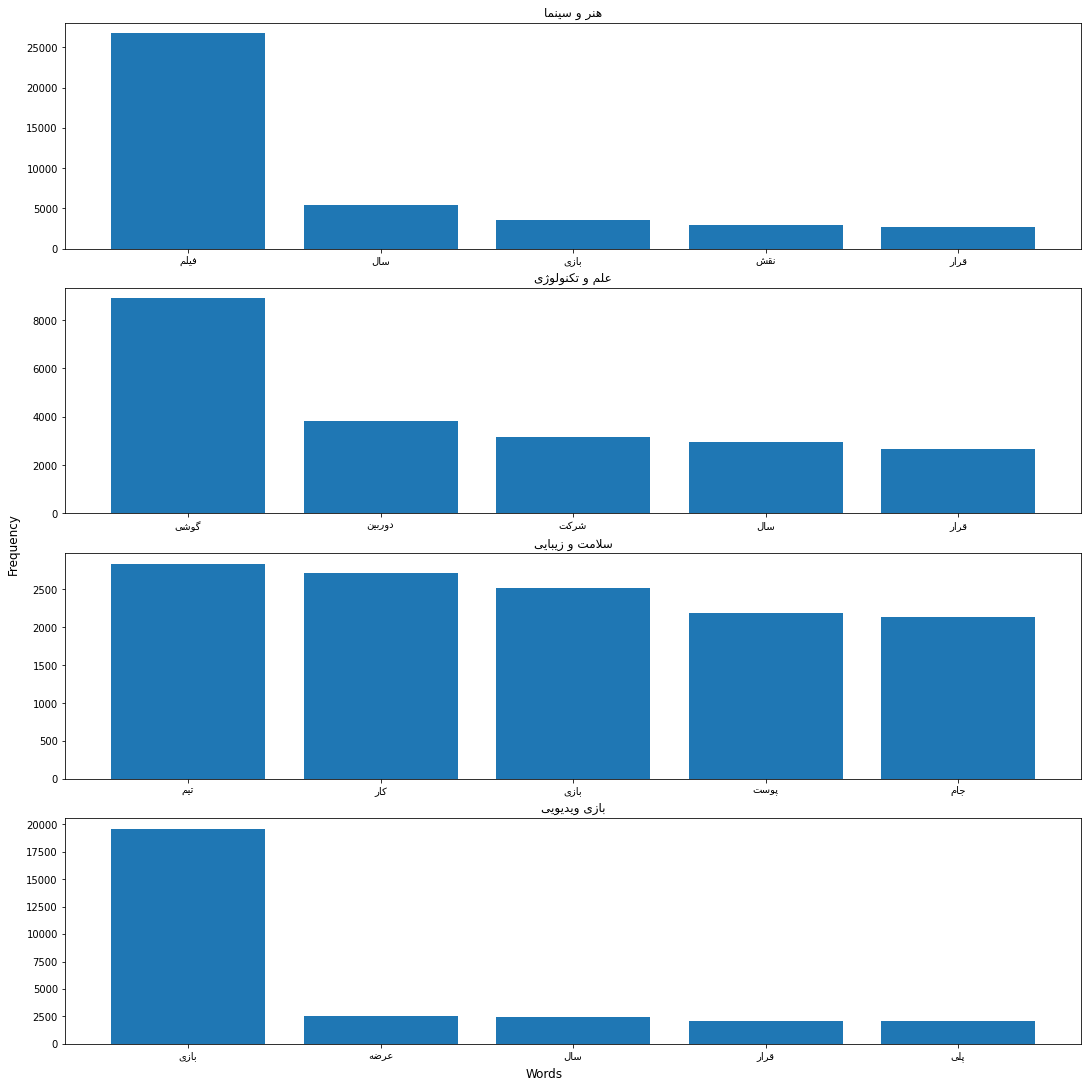

In [109]:
model = fit()
plot_frequent_words(model)

In [110]:
stop_words.update(['نقش', 'قرار', 'سال', 'بازی'])

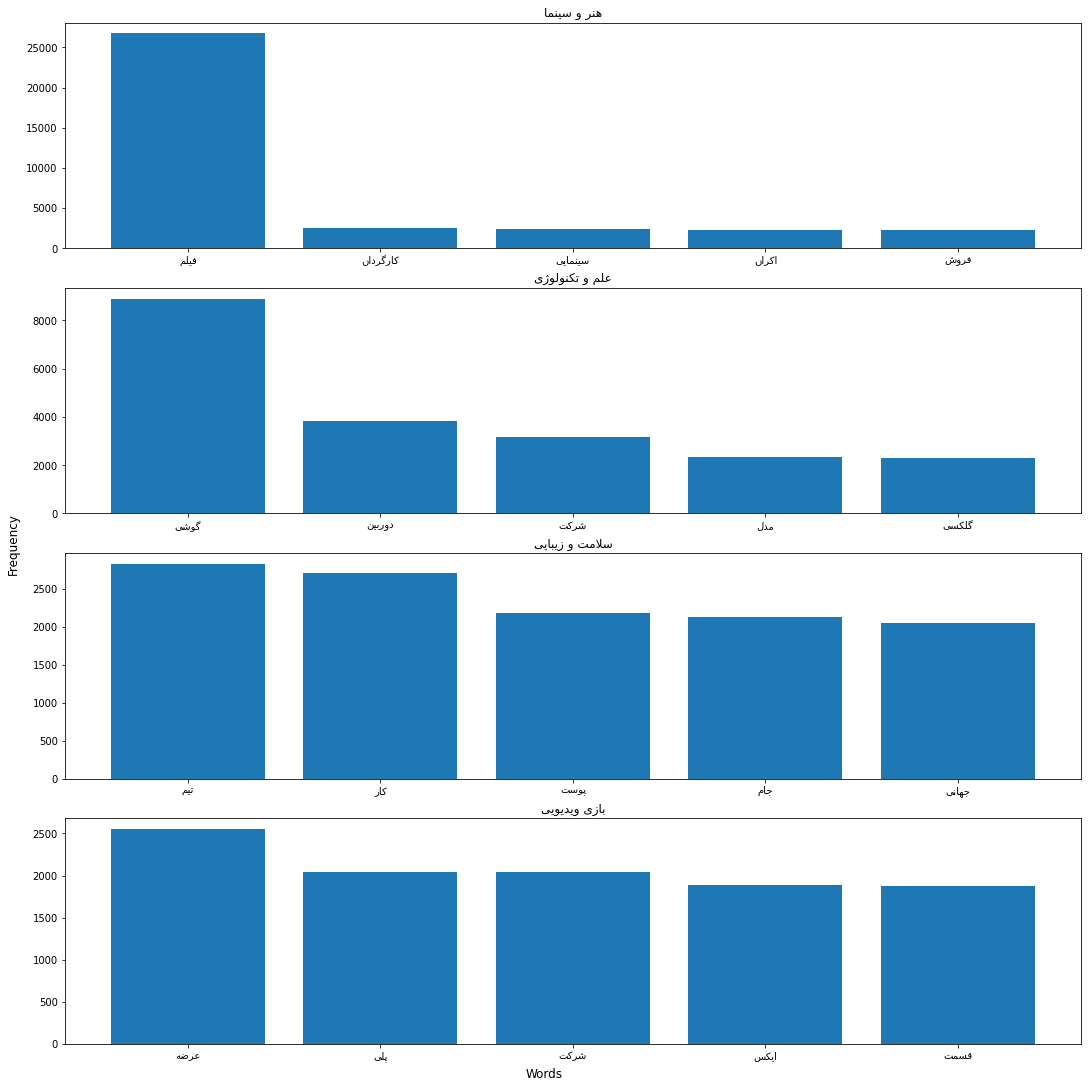

In [111]:
model = fit()
plot_frequent_words(model)

In [114]:
labels_prob = dict(zip(labels, [labels_frequency[label] / np.sum(labels_frequency) for label in labels]))

In [115]:
def calculate_score(label, ngrams, alpha=0):
    score = 0
    ZERO = 10**-100
    for ngram in ngrams:
        if ngram not in 


def predict(n=1, alpha=0):
    scores = dict(zip(labels, [0 for i in range(len(labels))]))
    for index, row in train_data.iterrows():
        words = preprocess(row['content'])
        ngrams = generate_ngrams(words, n)
        for label in labels:
            scores[label] = calculate_score(label, ngrams)


IndentationError: expected an indented block (99983624.py, line 8)

# Conclusion
